# Gesture Detection
Credit: https://q-viper.github.io/2020/08/01/gesture-based-visually-writing-system-using-opencv-and-python/

## Segmentation of Hand
***

### Background Subraction

Forground = Hands
Background = Everything other than hand

In [6]:
import cv2
from matplotlib import pyplot as plt 
import numpy as np
import imutils
import time

In [15]:
def show(img, figsize = (10, 10)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Matplotlib needs rgb
    figure = plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

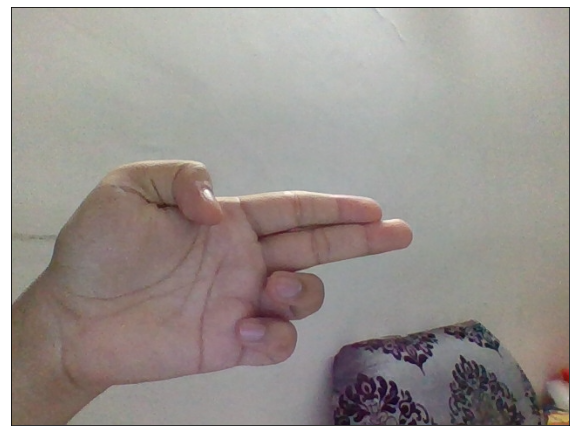

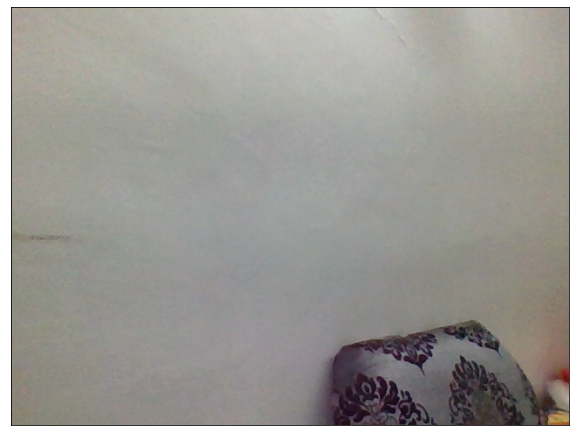

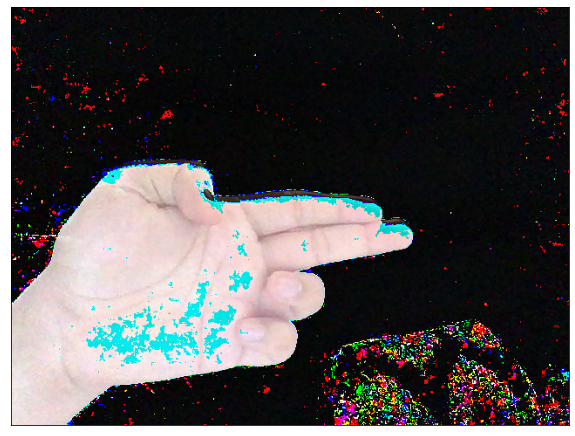

In [21]:
cap = cv2.VideoCapture(0) #run camera with device 
imgs = [] #list to hold frames
while len(imgs) < 2: #while we captured one foreground and one background image
    ret, frame = cap.read() #read each frame
    frame = cv2.flip(frame, 1) #flip the frame for anti-mirror effect
    key = cv2.waitKey(2) #wait for 2sec to check user key strike    
    if key == 32: #if key is space then show the frame, append it to our list
        show(frame)
        imgs.append(frame)
    cv2.imshow('Running Frame', frame) #keep showing our current frame 
    if key == 27 & 0xFF: #when escape key is pressed, exit
        break

cap.release() #release the camera and destroy windows
cv2.destroyAllWindows()
show(imgs[0]-imgs[1]) #background subtraction

### Generating a Mask:
The difference on image shows that the object on the wall was not on background image but is present on new image hence its color will be different than others and it will be easy to recognize them. Hence the object is foreground and the result will be called the mask.

For better performance, we will use concept of running average. We will run our system idle for some frames and then take average from it. We will make an average background. Then will do the absolute subtract. Also using RGB/BGR image on background subtraction only increase the complexity, so we will use the Grayscale image or ROI.

> *The **mask** is something that holds the foreground. In general, the difference image on above image also contains some sort of mask on the place where the object is present. The mask is generated by doing absolute subtraction of current frame with average background and then doing thresholding. The actual mask will contain black on unwanted region and white on our hand region. This is pretty simple idea, we are subtracting background with background image that contains hand, the difference will only be on hand region and all other parts will be black(RGB (0, 0, 0)).*


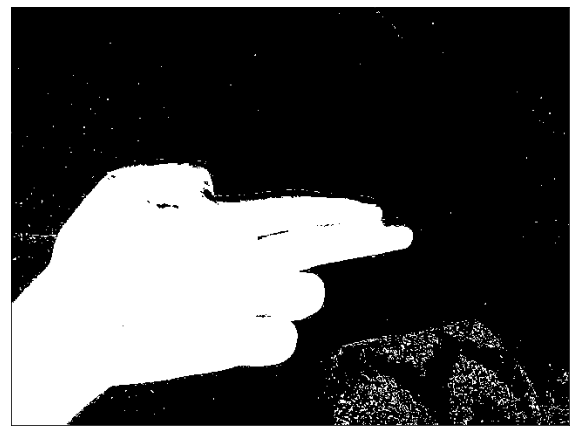

In [22]:
diff = np.abs(cv2.cvtColor(imgs[0], cv2.COLOR_BGR2GRAY)-cv2.cvtColor(imgs[1], cv2.COLOR_BGR2GRAY))
_, th = cv2.threshold(diff, 150, 255, cv2.THRESH_BINARY)
show(th)

### Contour Extraction
Contour must be around the hand. But because of the noise, we might have multiple contours and also can we hold our still? Also the shadows can effect. The contour with largest area is our hand region. `==> max(cnts, key=cv2.contourArea)`

The contour is the outer region where a object is located. On our case the contour must be around the hand. `==> cv2.RETR_EXTERNAL`

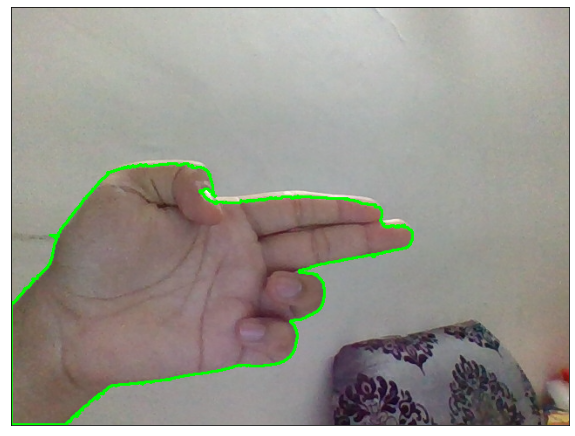

In [37]:
(cnts, _) = cv2.findContours(th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
segmented = max(cnts, key=cv2.contourArea)
cv2.drawContours(imgs[0], [segmented], -1, (0, 255, 0), 2)
show(imgs[0])

# Segmentation of Hand in Real Time
***

In [23]:
import cv2
from matplotlib import pyplot as plt 
import numpy as np
import imutils
import time

### Background Preparation
aweight: is the weight of the input image and decides the speed of updating. If set small, average is taken over large number of frames.

In [24]:
def running_average(bg_img, image, aweight):
    if bg_img is None:
        bg_img = image.copy().astype("float")
    else:
        cv2.accumulateWeighted(image, bg_img, aweight)    
    return bg_img

### Get Hand ContoursPermalink

In [25]:
def get_contours(bg_img, image, threshold=10):   
    diff = cv2.absdiff(bg_img.astype("uint8"), image) # abs diff betn img and bg
    _, th = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)
    (cnts, _) = cv2.findContours(th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)    
    if len(cnts) == 0:
        return None
    else:
        max_cnt = max(cnts, key=cv2.contourArea) #segmented
        return th, max_cnt

### Preparing Parameters, Variables, and Running Camera


In [26]:
aweight = 0.5 #accumulate weight variable
cam = cv2.VideoCapture(0) # strat the device camera
top, right, bottom, left = 250, 400, 480, 640 # ROI box
num_frames=0 # count frame
canvas = None # writing canvas
t=3 # thickness
draw_color = (0, 255, 0) # draw color(ink color)
pointer_color = (255, 0, 0) # pointer color
erase = False # mode flag
take_average=True # flag to indicate take average
bg_img=None #bg image

In [27]:
pTime = 0
while True: # loop while everything is true
    (ret, frame) = cam.read() # read the camera result    
    if ret: # if camera has read frame    
        # FPS Calculation
        cTime = time.time()
        fps = 1/(cTime - pTime)
        pTime = cTime    

        frame = imutils.resize(frame, width=700)        
        frame = cv2.flip(frame, 1) # flip to remove mirror effect        
        clone = frame.copy() # clone it to not mess with real frame
        h, w = frame.shape[:2]        
        roi = frame[top:bottom, right:left] # take roi, to send it onto contour/average extraction        
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY) # roi to grayscale        
        gray = cv2.GaussianBlur(gray, (7, 7), 0) # add GaussianBlur to eliminate some noise
        
        if num_frames < 100 and take_average == True: # if to take average and num frames on average taking is lesser 
            bg_img = running_average(bg_img, gray, aweight) # perform running average            
            cv2.putText(clone, str(num_frames), (40, 100),
                                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 5) # put frame number on frame
            cv2.putText(clone, '[STATUS]: please wait! calibrating...', (40, 150),
                                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 5) # put frame number on frame
            if num_frames == 1:
                print('[STATUS]: please wait! calibrating...')
            if num_frames == 99:
                print('[STATUS]: Calibrating Success...')
            num_frames += 1      
            
        else: # if not to take average
            num_frames = 0                               
            hand = get_contours(bg_img, gray) # take our segmented hand
            take_average=False
            if hand is not None:
                thresholded, segmented = hand
                cv2.drawContours(clone, [segmented+(right,top)], -1, (0, 255, 0), 2)    
                cv2.imshow("mask", thresholded)  

        cv2.rectangle(clone, (left, top), (right, bottom), (0, 0, 255), 2) # draw a ROI  on clone      
        cv2.putText(clone, f'FPS: {int(fps)}', (40,50), cv2.FONT_HERSHEY_COMPLEX, 0.7, (255,0,0), 2)
        cv2.imshow("Feed", clone) # show live feed

        key = cv2.waitKey(1) & 0xFF # wait for 1ms to key press
        if key==27 or key == ord('q'): # if pressed  escape, loop out and stop processing
            break
cam.release()
cv2.destroyAllWindows()

[STATUS]: please wait! calibrating...
[STATUS]: Calibrating Success...


# Implementation of Gesture Detection
***
#### 1. Draw on Canvas 
#### 2. Count Fingers

## Draw on Canvas

In [5]:
import cv2
from matplotlib import pyplot as plt 
import numpy as np
import imutils
import time

In [6]:
def running_average(bg_img, image, aweight):
    if bg_img is None:
        bg_img = image.copy().astype("float")
    else:
        cv2.accumulateWeighted(image, bg_img, aweight)    
    return bg_img
def get_contours(bg_img, image, threshold=10):   
    diff = cv2.absdiff(bg_img.astype("uint8"), image) # abs diff betn img and bg
    _, th = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)
    (cnts, _) = cv2.findContours(th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)    
    if len(cnts) == 0:
        return None
    else:
        max_cnt = max(cnts, key=cv2.contourArea) #segmented
        return th, max_cnt

We want to draw a pointer only inside the ROI box and not outside. And also the contours are found on the corpped ROI image hence we need to add right and top values. The writing canvas is first initialzed with zeros and then added 255, thanks to NumPy array broadcasting, hence canvas became complete white. The variable c here is very important one and it is responsible to show the pointer. The pointer window is equal to the canvas, and pointer image is 0 on every place except where the minimum position of contour is.

We want to draw a pointer only inside the ROI box and not outside. And also the contours are found on the corpped ROI image hence we need to add right and top values. The writing canvas is first initialzed with zeros and then added 255, thanks to NumPy array broadcasting, hence canvas became complete white. The variable c here is very important one and it is responsible to show the pointer. The pointer window is equal to the canvas, and pointer image is 0 on every place except where the minimum position of contour is.

In [17]:
aweight = 0.5 #accumulate weight variable
cam = cv2.VideoCapture(0) # strat the device camera
top, right, bottom, left = 250, 400, 480, 640 # ROI box
num_frames=0 # count frame
canvas = None # writing canvas
t=3 # thickness
draw_color = (0, 255, 0) # draw color(ink color)
pointer_color = (255, 0, 0) # pointer color
erase = False # mode flag
take_average=True # flag to indicate take average
bg_img=None #bg image
pTime = 0
#===================================================================================================================================            
while True: # loop while everything is true
    (ret, frame) = cam.read() # read the camera result    
    if ret: # if camera has read frame    
        # FPS Calculation
        cTime = time.time()
        fps = 1/(cTime - pTime)
        pTime = cTime    

        frame = imutils.resize(frame, width=700)        
        frame = cv2.flip(frame, 1) # flip to remove mirror effect        
        clone = frame.copy() # clone it to not mess with real frame
        h, w = frame.shape[:2]        
        roi = frame[top:bottom, right:left] # take roi, to send it onto contour/average extraction        
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY) # roi to grayscale        
        gray = cv2.GaussianBlur(gray, (7, 7), 0) # add GaussianBlur to eliminate some noise
        
        if num_frames < 100 and take_average == True: # if to take average and num frames on average taking is lesser 
            bg_img = running_average(bg_img, gray, aweight) # perform running average            
            cv2.putText(clone, str(num_frames), (40, 100),
                                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 5) # put frame number on frame
            cv2.putText(clone, '[STATUS]: please wait! calibrating...', (40, 150),
                                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 5) # put frame number on frame
            if num_frames == 1:
                print('[STATUS]: please wait! calibrating...')
            if num_frames == 99:
                print('[STATUS]: Calibrating Success...')
            num_frames += 1      
#===================================================================================================================================            
        else: # if not to take average
            num_frames = 0                               
            hand = get_contours(bg_img, gray) # take our segmented hand
            take_average=False
            if hand is not None:
                thresholded, segmented = hand
                cv2.drawContours(clone, [segmented+(right,top)], -1, (0, 255, 0), 2)    
                #-----------------------------------------------------------------------------
                tshape = thresholded.shape
                sshape = segmented.shape
                new_segmented = segmented.reshape(sshape[0], sshape[-1]) #sreshapes segmented to 'shape[0]' rows, and 'sshape[-1]' columns without changing the data
                m = new_segmented.min(axis= 0) #find the minimum value within each column by specifying axis=0
                
                if type(canvas) == type(None):
                    canvas = np.zeros((tshape[0], tshape[1], 3))+255
                c = np.zeros(canvas.shape, dtype=np.uint8)
                cv2.putText(c, f'{m[0]},{m[1]}', (m[0], m[1]-20), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,0,255), 2)
                cv2.circle(c, (m[0], m[1]), 5, pointer_color, -3) 
                cv2.putText(clone, f'{right+m[0]},{top+m[1]}', (right+m[0], top+m[1]-20), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,0,255), 2)     
                cv2.circle(clone, (right+m[0], top+m[1]), 5, pointer_color, -3)
                #-----------------------------------------------------------------------------
                cv2.circle(canvas, (m[0], m[1]), 5, draw_color, -3)
                e = cv2.erode(canvas, (3, 3), iterations=5)
                drawn = e
                #drawn = cv2.resize(e, (clone.shape[1], clone.shape[0]))
                #c = cv2.resize(c, (clone.shape[1], clone.shape[0]))
                drawn_new = drawn+c
                #-----------------------------------------------------------------------------
                cv2.imshow("mask", thresholded)
                cv2.imshow("C", c)
                cv2.imshow("Drawing", drawn+c)
#=================================================================================================================================== 
        cv2.rectangle(clone, (left, top), (right, bottom), (0, 0, 255), 2) # draw a ROI  on clone      
        cv2.putText(clone, f'FPS: {int(fps)}', (40,50), cv2.FONT_HERSHEY_COMPLEX, 0.7, (255,0,0), 2)
        cv2.imshow("Feed", clone) # show live feed

        key = cv2.waitKey(1) & 0xFF # wait for 1ms to key press
        if key==27 or key == ord('q'): # if pressed  escape, loop out and stop processing
            break
cam.release()
cv2.destroyAllWindows()

[STATUS]: please wait! calibrating...
[STATUS]: Calibrating Success...


Well, on canvas, on the position where the minimum position of contour is present, we draw a circle of given thickness with different color than pointer. The canvas, pointer, thresholded, ROI image all will be of same size but we want it to be just same as our live feed, hence we resize it. But why doing erosion? Erosion is used here to make image lesser noisy or more thick around drawn circle. The canvas here is original canvas. And we don’t do anything than writing on it. But we resize the erosion result. Then to show the drawn color and pointer at the same time on canvas, we will sum the canvas with pointer image. The beauty of black image summing with any image is so awesome here.

> *Basics of Erosion:*
> 1. *Erodes away the boundaries of the foreground object*
> 2. *Used to diminish the features of an image.*
> 3. *A kernel(a matrix of odd size(3,5,7) is convolved with the image.*
> 4. *A pixel in the original image (either 1 or 0) will be considered 1 only if all the pixels under the kernel are 1, otherwise, it is eroded (made to zero).*
> 5. *Thus all the pixels near the boundary will be discarded depending upon the size of the kernel.*
> 6. *So the thickness or size of the foreground object decreases or simply the white region decreases in the image.*
> 7. *It is useful for removing small white noises.*
> 8. *Used to detach two connected objects etc*

## Count Fingers

In [29]:
import cv2
from matplotlib import pyplot as plt 
import numpy as np
import imutils
import time
from sklearn.metrics import pairwise

In [19]:
def running_average(bg_img, image, aweight):
    if bg_img is None:
        bg_img = image.copy().astype("float")
    else:
        cv2.accumulateWeighted(image, bg_img, aweight)    
    return bg_img
def get_contours(bg_img, image, threshold=10):   
    diff = cv2.absdiff(bg_img.astype("uint8"), image) # abs diff betn img and bg
    _, th = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)
    (cnts, _) = cv2.findContours(th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)    
    if len(cnts) == 0:
        return None
    else:
        max_cnt = max(cnts, key=cv2.contourArea) #segmented
        return th, max_cnt

In [30]:
def count(thresholded, segmented):
    # find the convex hull of the segmented hand region
    chull = cv2.convexHull(segmented)

    # find the most extreme points in the convex hull
    extreme_top    = tuple(chull[chull[:, :, 1].argmin()][0])
    extreme_bottom = tuple(chull[chull[:, :, 1].argmax()][0])
    extreme_left   = tuple(chull[chull[:, :, 0].argmin()][0])
    extreme_right  = tuple(chull[chull[:, :, 0].argmax()][0])

    # find the center of the palm
    cX = int((extreme_left[0] + extreme_right[0]) / 2)
    cY = int((extreme_top[1] + extreme_bottom[1]) / 2)

    # find the maximum euclidean distance between the center of the palm
    # and the most extreme points of the convex hull
    distance = pairwise.euclidean_distances([(cX, cY)], Y=[extreme_left, extreme_right, extreme_top, extreme_bottom])[0]
    maximum_distance = distance[distance.argmax()]

    # calculate the radius of the circle with 80% of the max euclidean distance obtained
    radius = int(0.8 * maximum_distance)

    # find the circumference of the circle
    circumference = (2 * np.pi * radius)

    # take out the circular region of interest which has 
    # the palm and the fingers
    circular_roi = np.zeros(thresholded.shape[:2], dtype="uint8")
	
    # draw the circular ROI
    cv2.circle(circular_roi, (cX, cY), radius, 255, 1)

    # take bit-wise AND between thresholded hand using the circular ROI as the mask
    # which gives the cuts obtained using mask on the thresholded hand image
    circular_roi = cv2.bitwise_and(thresholded, thresholded, mask=circular_roi)

    # compute the contours in the circular ROI
    (cnts, _) = cv2.findContours(circular_roi.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # initalize the finger count
    count = 0

    # loop through the contours found
    for c in cnts:
        # compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)

        # increment the count of fingers only if -
        # 1. The contour region is not the wrist (bottom area)
        # 2. The number of points along the contour does not exceed
        #     25% of the circumference of the circular ROI
        if ((cY + (cY * 0.25)) > (y + h)) and ((circumference * 0.25) > c.shape[0]):
            count += 1

    return count


In [33]:
aweight = 0.5 #accumulate weight variable
cam = cv2.VideoCapture(0) # strat the device camera
top, right, bottom, left = 250, 400, 480, 640 # ROI box
num_frames=0 # count frame
take_average=True # flag to indicate take average
bg_img=None #bg image
pTime = 0
#===================================================================================================================================            
while True: # loop while everything is true
    (ret, frame) = cam.read() # read the camera result    
    if ret: # if camera has read frame    
        # FPS Calculation
        cTime = time.time()
        fps = 1/(cTime - pTime)
        pTime = cTime    

        frame = imutils.resize(frame, width=700)        
        frame = cv2.flip(frame, 1) # flip to remove mirror effect        
        clone = frame.copy() # clone it to not mess with real frame
        h, w = frame.shape[:2]        
        roi = frame[top:bottom, right:left] # take roi, to send it onto contour/average extraction        
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY) # roi to grayscale        
        gray = cv2.GaussianBlur(gray, (7, 7), 0) # add GaussianBlur to eliminate some noise
        
        if num_frames < 100 and take_average == True: # if to take average and num frames on average taking is lesser 
            bg_img = running_average(bg_img, gray, aweight) # perform running average            
            cv2.putText(clone, str(num_frames), (40, 100),
                                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 5) # put frame number on frame
            cv2.putText(clone, '[STATUS]: please wait! calibrating...', (40, 150),
                                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 5) # put frame number on frame
            if num_frames == 1:
                print('[STATUS]: please wait! calibrating...')
            if num_frames == 99:
                print('[STATUS]: Calibrating Success...')
            num_frames += 1      
#===================================================================================================================================            
        else: # if not to take average
            num_frames = 0                               
            hand = get_contours(bg_img, gray) # take our segmented hand
            take_average=False
            if hand is not None:
                thresholded, segmented = hand
                cv2.drawContours(clone, [segmented+(right,top)], -1, (0, 255, 0), 2)    
                fingers = count(thresholded, segmented)
                cv2.putText(clone, str(fingers), (150, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
                #time.sleep(2)
                
            cv2.imshow("mask", thresholded)
#=================================================================================================================================== 
        cv2.rectangle(clone, (left, top), (right, bottom), (0, 0, 255), 2) # draw a ROI  on clone      
        cv2.putText(clone, f'FPS: {int(fps)}', (40,50), cv2.FONT_HERSHEY_COMPLEX, 0.7, (255,0,0), 2)
        cv2.imshow("Feed", clone) # show live feed

        key = cv2.waitKey(1) & 0xFF # wait for 1ms to key press
        if key==27 or key == ord('q'): # if pressed  escape, loop out and stop processing
            break
cam.release()
cv2.destroyAllWindows()

[STATUS]: please wait! calibrating...
[STATUS]: Calibrating Success...
